In [51]:
from zipfile import ZipFile
import pathlib
from datetime import datetime
from dateutil import parser

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 0
np.random.seed(random_seed)

The `sentiment140` dataset contains 1,600,000 tweets extracted using the twitter api.

The tweets have been annotated *(0 = negative, 4 = positive)* and they can be used to detect sentiment.

It contains the following 6 fields:
- `target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- `ids`: The id of the tweet ( 2087)
- `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.
- `user`: the user that tweeted (robotickilldozr)
- `text`: the text of the tweet (Lyx is cool)

In [2]:
source = pathlib.Path(pathlib.Path().absolute(), 'data', 'sentiment140.zip')

In [151]:
import charset_normalizer
with open(source, 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(1000000))
result

{'encoding': None, 'language': '', 'confidence': None}

In [153]:
# Method 2
df = pd.read_csv(
    source, 
    compression='zip', 
    #encoding='cp1252', 
    encoding = 'latin1',
    header=None, 
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    #parse_dates=['date'],
    #infer_datetime_format=True,
    #date_parser=parse_tweet_dates,
)

In [154]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1600000, 6)

#### Regardons les types des colonnes et ajustons si nécessaire

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df = df.astype({
    "target": 'category', 
    "ids": 'category',
    #"date": 'datetime64',
    "flag": 'category',
    "user": 'category',
    #"text": 'object',
})

In [7]:
df.dtypes

target    category
ids       category
date        object
flag      category
user      category
text        object
dtype: object

In [8]:
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


### Commençons par chercher les éventuels doublons

#### Vérifions sur l'ensemble des colonnes

In [9]:
df.duplicated().sum()

0

#### A présent, vérifions sans tenir compte de la `target` au cas ou certains doublons auraient les deux valeurs

In [10]:
subset = ['ids', 'date', 'flag', 'user', 'text']
df.duplicated(subset=subset).sum()

1685

In [11]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
1394129,4,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
385331,0,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
1077756,4,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
184535,0,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
118605,0,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
968532,4,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
1443107,4,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
419860,0,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
190549,0,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again
1086997,4,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again


>#### On constate que l'on a 1685 échantillons pour lesquels on a à la fois une target *positive* (4) et une target *negative* (0)...
> comme on ne connait pas la véritable target des ces échantillons en double, il nous faut supprimer les 3370 *(2 x 1685)*

In [12]:
df.drop_duplicates(keep=False, subset=subset, inplace=True)

In [13]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1596630, 6)

In [14]:
df.ids.duplicated().sum()

0

In [15]:
df.ids.describe()

count        1596630
unique       1596630
top       1467810369
freq               1
Name: ids, dtype: int64

#### Enfin, vérifions si l'on a des `textes` qui apparaissent plusieurs fois avec la même `target`

In [16]:
subset= ['text']
df.duplicated(subset=subset).sum()

16836

In [17]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
271505,0,1990029536,Mon Jun 01 03:38:42 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
271472,0,1990023076,Mon Jun 01 03:37:19 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
1132074,4,1975956536,Sat May 30 16:16:11 PDT 2009,NO_QUERY,dstocum,bathroom is clean..... now on to more enjoya...
1132076,4,1975956610,Sat May 30 16:16:11 PDT 2009,NO_QUERY,DavidStocum,bathroom is clean..... now on to more enjoya...
540173,0,2199659424,Tue Jun 16 17:49:15 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
540159,0,2199656747,Tue Jun 16 17:49:00 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
1364947,4,2049859280,Fri Jun 05 17:37:43 PDT 2009,NO_QUERY,MonicaEira,#seb-day #seb-day #seb-day #seb-day #seb-day ...
1357123,4,2047924312,Fri Jun 05 14:23:16 PDT 2009,NO_QUERY,DihDesrosiers,#seb-day #seb-day #seb-day #seb-day #seb-day ...
331063,0,2012536119,Tue Jun 02 20:49:46 PDT 2009,NO_QUERY,iShatara,*tear*
287201,0,1994140773,Mon Jun 01 11:28:38 PDT 2009,NO_QUERY,vanitiiluv,*tear*


>#### On constate que l'on a encore 16836 échantillons dont les textes apparaissent plusieurs fois dans le jeu de données
> il convient donc de n'en garder qu'un seul exemplaire de chaque

In [18]:
df.drop_duplicates(keep='first', subset=subset, inplace=True)

In [19]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 6)

In [20]:
df.text.describe()

count                                               1579794
unique                                              1579794
top       @switchfoot http://twitpic.com/2y1zl - Awww, t...
freq                                                      1
Name: text, dtype: object

### Analysons la colonne `target`
#### Regardons sa distribution

In [21]:
df.target.value_counts()

4    791281
0    788513
Name: target, dtype: int64

>#### On constate donc que les targets sont équitablement distribuées entre 0 *(negative)* et 4 *(positive)*, mais qu'il n'y a pas de 2 *(neutral)*
> il n'est donc pas nécessaire d'effectuer un ré-équilibrage, mais nous pourrions changer la colonne en bool ou rendre les labels plus clairs.

In [22]:
remap = {0: "negative", 4: "positive"}
df.replace({"target": remap}, inplace=True)

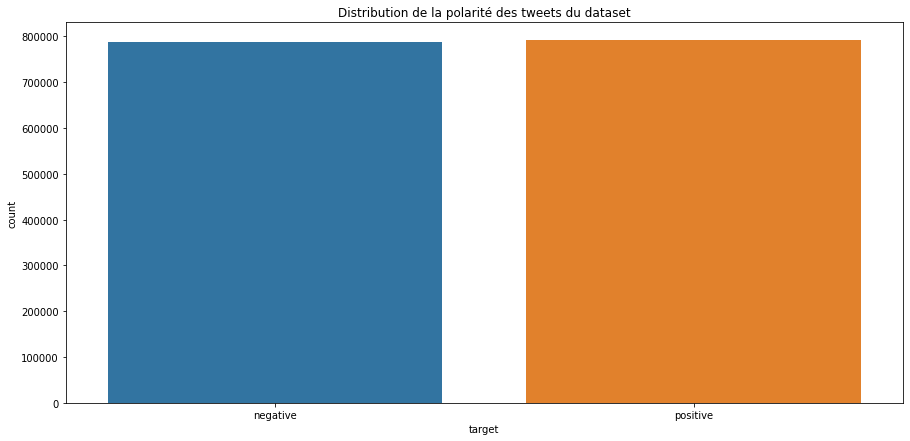

In [23]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(data=df.target.value_counts().reset_index().rename(columns={'target':'count', 'index':'target'}), x='target', y='count')
plt.title("Distribution de la polarité des tweets du dataset")
plt.show()

### Analysons la colonne `ids`

In [24]:
df.ids.duplicated().sum()

0

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `ids` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [25]:
df.drop(columns=['ids'], inplace=True)

In [26]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,negative,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

### Analysons la colonne `date`

In [27]:
def parse_tweet_dates(date_time_str):
    return parser.parse(date_time_str,  tzinfos={"PDT": -7*3600})

In [28]:
df['date'] = df.date.apply(parse_tweet_dates)

In [29]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,negative,2009-04-06 22:19:45-07:00,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,2009-04-06 22:19:49-07:00,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

#### Regardons les limites de la periode de publication des tweets de notre dataset

In [30]:
df.date.describe(datetime_is_numeric=True)

count                                1579794
mean     2009-05-31 06:53:34.174260992-07:00
min                2009-04-06 22:19:45-07:00
25%                2009-05-28 22:53:24-07:00
50%                2009-06-02 02:56:40-07:00
75%                2009-06-15 05:14:33-07:00
max                2009-06-25 10:28:31-07:00
Name: date, dtype: object

>#### On a donc des tweets dont les dates s'étalent du 06/04/2009 au 25/06/2009
> Il n'y a pas de raison que le lexique utilisé pour qualifier ce qui est *positif* ou *négatif* change en si peu de temps, donc on peut conserver l'ensemble de l'intervalle

#### Regardons à présent la distribution des tweet dans le temps

In [31]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, x_label=None, y_label="Nombre de commandes"):

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    if show_values:
        ax.bar_label(ax.containers[0])
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

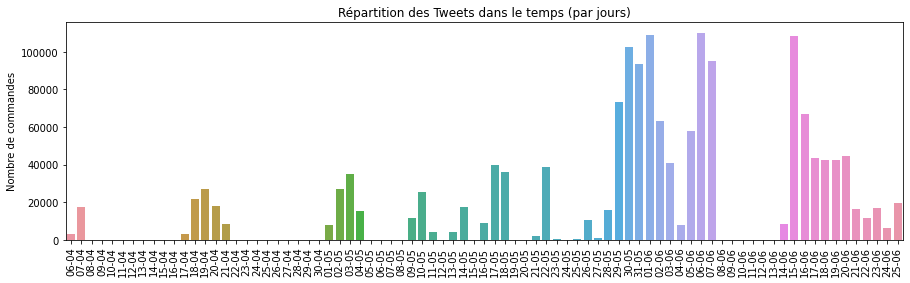

In [32]:
select = df[['date']].copy()
select['short_date'] = select.date.apply(lambda x: x.strftime("%Y-%m-%d"))
#selection['short_date'] = selection.date.apply(lambda x: datetime.strptime(x[4:10] + x[-5:], "%b %d %Y").strftime("%m %d %Y"))
select = pd.DataFrame(select.groupby('short_date').size(), columns=['count'])# .sort_values('short_date')

# add missing dates
idx = pd.date_range('2009-04-06', '2009-06-25')
select.reset_index(inplace=True)
select.index = pd.DatetimeIndex(select['short_date'])
select = select.reindex(idx, fill_value=0)
select = select.drop(columns=['short_date'])
select.index = select.index.strftime('%d-%m')
    
plot_bars(select.T, "Répartition des Tweets dans le temps (par jours)", labels_modulo=1, show_values=False)

>#### On constate que tweets sont inégalement répartis sur notre intervalle de temps
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données à ce stade)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `date` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [33]:
df.drop(columns=['date'], inplace=True)

In [34]:
display(df.head(2), df.shape)

,target,flag,user,text
0,negative,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 4)

### Analysons la colonne `flag`

In [35]:
df.flag.value_counts(dropna=False)

NO_QUERY    1579794
Name: flag, dtype: int64

>#### Il n'y a qu'une seule valeur dans cette colonne
> elle ne présente donc aucun intérêt et peut être retirée.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `flag` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [36]:
df.drop(columns=['flag'], inplace=True)

In [37]:
display(df.head(2), df.shape)

,target,user,text
0,negative,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 3)

### Analysons la colonne `user`

In [38]:
df.user.describe()

count      1579794
unique      653858
top       lost_dog
freq           549
Name: user, dtype: object

>#### On a une répartition inégale du nombre de Tweets par utilisateurs
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données à ce stade)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `user` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [39]:
df.drop(columns=['user'], inplace=True)

In [40]:
display(df.head(2), df.shape)

,target,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...


(1579794, 2)

### Analysons la colonne `text`

In [41]:
df.duplicated(subset=['text']).sum()

0

#### Visualisons le jeu de données avant la tokenisation

In [43]:
from wordcloud import WordCloud

In [44]:
from PIL import Image

In [62]:
def plot_wordcloud(text, from_frequency=False, name="wordcloud"):
    mask = np.array(Image.open("medias/twitter.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud_export = WordCloud(background_color=None, mode="RGBA", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=mask)
    wordcloud_clean = WordCloud(background_color="White", mode="RGB", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=mask)
    
    if from_frequency:
        wordcloud_export = wordcloud_export.generate_from_frequencies(text)
        wordcloud_clean = wordcloud_clean.generate_from_frequencies(text)
    else:
        wordcloud_export = wordcloud_export.generate(text)
        wordcloud_clean = wordcloud_clean.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud_clean, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
    # Export
    wordcloud_export.to_file(f"medias/{name}.png")
    
    #fig.savefig(f"medias/{name}.png", transparent=True)

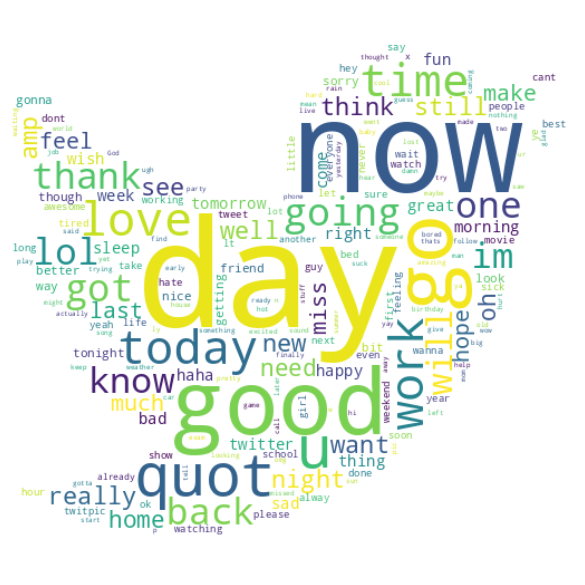

In [63]:
plot_wordcloud(" ".join([x for x in df.text]), name="wordcloud1")

#### Répartition de la taille des tweets

In [155]:
def plot_tweet_sizes(data, col_name, x_label, y_label, title1, title2):
    select = pd.DataFrame(data[col_name].value_counts()).reset_index()
    select.sort_values(by='index', inplace=True)
    select.set_index('index', inplace=True)

    size_mean = data[col_name].mean()
    size_median = data[col_name].median()
    max_count = np.array(select).max()

    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    sns.lineplot(data=select, y=col_name, x='index')
    plt.plot([size_mean, size_mean],[0,max_count], label=f"Moyenne ({size_mean:.2f})", alpha=0.5)
    plt.plot([size_median, size_median],[0,max_count], label=f"Médiane ({size_median:.2f})", alpha=0.5)
    plt.title(title1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.ylim(0,10000)
    plt.legend()

    select2 = np.cumsum(select)

    plt.subplot(1,2,2)
    sns.lineplot(data=select2, y=col_name, x='index')
    plt.title(title2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

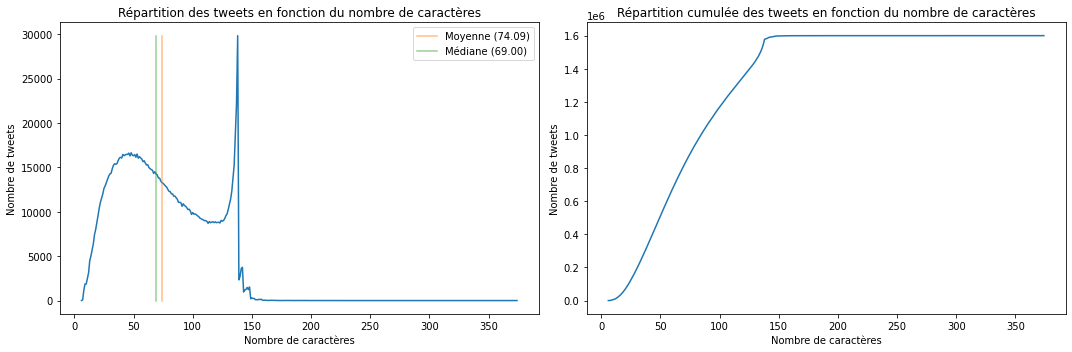

In [156]:
data_tmp = df.copy()
data_tmp['tweet_chars'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_tmp, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

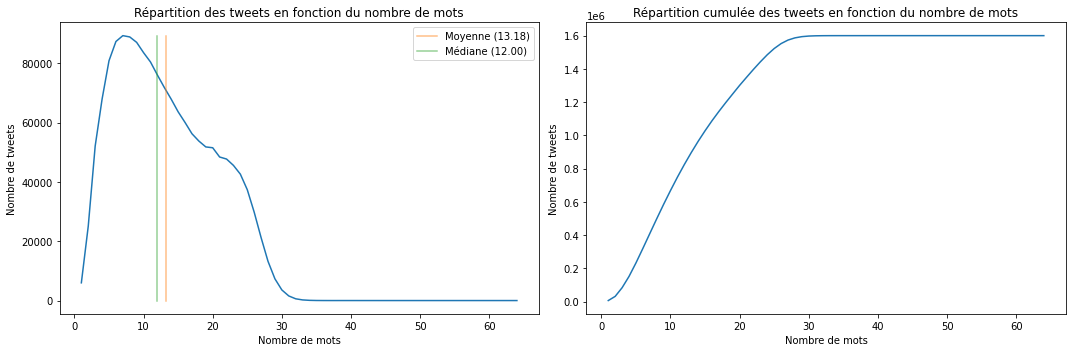

In [157]:
data_tmp['tweet_words'] = df.text.apply(lambda x: len(x.split()))
plot_tweet_sizes(
    data_tmp, 
    col_name = 'tweet_words', 
    title1 = "Répartition des tweets en fonction du nombre de mots",
    title2 = "Répartition cumulée des tweets en fonction du nombre de mots",
    x_label = "Nombre de mots",
    y_label = "Nombre de tweets",
)

In [158]:
data_tmp.describe()

,target,ids,tweet_chars,tweet_words
count,1.600000e+06,1.600000e+06,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09,7.409011e+01,1.317615e+01
std,2.000001e+00,1.935761e+08,3.644114e+01,6.957978e+00
min,0.000000e+00,1.467810e+09,6.000000e+00,1.000000e+00
25%,0.000000e+00,1.956916e+09,4.400000e+01,7.000000e+00
50%,2.000000e+00,2.002102e+09,6.900000e+01,1.200000e+01
75%,4.000000e+00,2.177059e+09,1.040000e+02,1.900000e+01
max,4.000000e+00,2.329206e+09,3.740000e+02,6.400000e+01


>#### Il se pourrait que l'on ait des outliers à traiter.
> En effet, ef 2009 la limite de caractères des tweets était de 140 or on constate que 17009 dépassent cette limite

#### Explorons davantages pour comprendre si ce sont des outliers ou pas

In [159]:
(data_tmp.tweet_chars > 140).sum()

17174

In [160]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head(10)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

@neospace à¹à¸£à¸·à¹à¸­à¸à¸à¸±à¹à¸à¸à¸£à¸£à¸à¹à¸à¸£à¸² à¹à¸«à¹à¸à¸à¹à¸§à¸¢à¸à¸µà¹à¹à¸¡à¹à¸à¹à¸­à¸à¹à¸à¸à¸±à¹à¸à¹à¹à¸¥à¹à¸à¸?à¸²à¸£à¹à¸¡à¸·à¸­à¸ &quot;à¸à¹à¸²à¸à¸à¸à¸&quot; à¸?à¸±à¸à¸­à¸µà¸? à¹?à¸à¹à¸à¸µ

In [161]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head(10)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@stum450n Hi. Thanks for the follow. Nice website... check your carriage returns though, the bottom of 'Website &amp; brand identity' is out  141

FollowFriday @susanlinger @jackiebrass  &amp; whole lot more really great people that I really do follow but this week these interacted w me  141

Just Paid My Phone Bill..&amp; Bout To Pay On The Monthly Tuition Fund. Feeling A Little Better Knowing I Have Those Out The Way  Whats Good? 141

Pissed i cant go to the making of @pushplaycj @pushplayderek @pushplaysteve &amp; @pushplaynick's music video because finals start then! Agh  141

@Moonshayde hah! Hunter's 'outside' is me cuddling him whilst i step onto the balcony &amp; spit down at the yups gossipping about me below.  141

Mariyam Peyton -&gt;  Being Shauky:  im missing u guys .. kisses to lana nd aiz. hope evri ones gud. lov frm mom nd koky- Miss u too baby sis 141

@jeffpulver Would love to hear more about #HDComms &amp; HD VOIP technology. Where can I read up abt it? Or can u teac

In [162]:
from bs4 import BeautifulSoup

In [171]:
def convert_html(x):
    return BeautifulSoup(x, 'html.parser').get_text()

df['text'] = df.text.apply(convert_html)

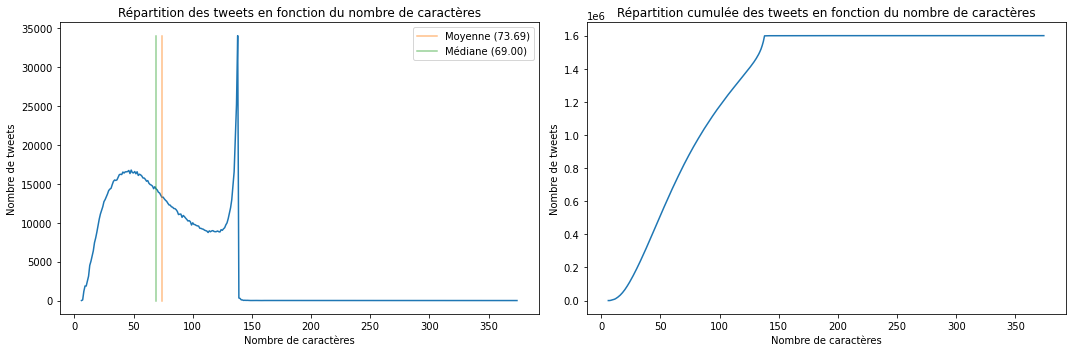

In [172]:
data_tmp = df.copy()
data_tmp['tweet_chars'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_tmp, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

In [173]:
(data_tmp.tweet_chars > 140).sum()

686

In [176]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

5 days till new top gear  î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?

In [177]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers  141

@KyleKorver  Hello kyle Â¡Â¡ I Will go to see you in October vs Real Madrid in Spain ; iÂ´m a very fan for utah and for you Â¡Â¡ One embrace  141

that which is tall, has to be deep in order to sustain.  Sometimes, I say â like spiderwoman â let me scale the sides.  2day a great day! 141

Iï¿½m gettin' dress! I stayed wiz Ruth & weï¿½ll make a tourist route through the city... with a car of the era of the 50s! Iï¿½ll get a pic  141

@usako_minamino hehe cÃ¡i miroticon ss ko xem ÄÃ¢u, fáº£i chá»«a Äá» má»t Äc táº­n máº¯t xem chá»©  ss Äag rÃ¡g kiá»?m lÃ²g Äai... =.= 141



In [83]:
data_tmp[data_tmp.tweet_size == 1].shape

(4544, 3)

>#### On constate que :
> - la moitié des reviews ont moins de 12 "mots"
> - aucun des 1.579.794 tweets ont 0 "mot"... 
> - 4544 des 1.579.794 tweets ont 1 "mot"...

In [84]:
data_tmp.tweet_size.quantile(0.99)

28.0

In [91]:
(data_tmp.tweet_size > 28).sum()

13259

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Faut-il supprimer les tweets de 1 mot
> - ❌ Faut-il supprimer les outliers *(plus de 28 mots / 0.99 quantiles ?)*. Ils risquent d'utiliser des mots non réprésentatifs.
<br><u>*~~(action: fait ci-dessous)~~*</u>

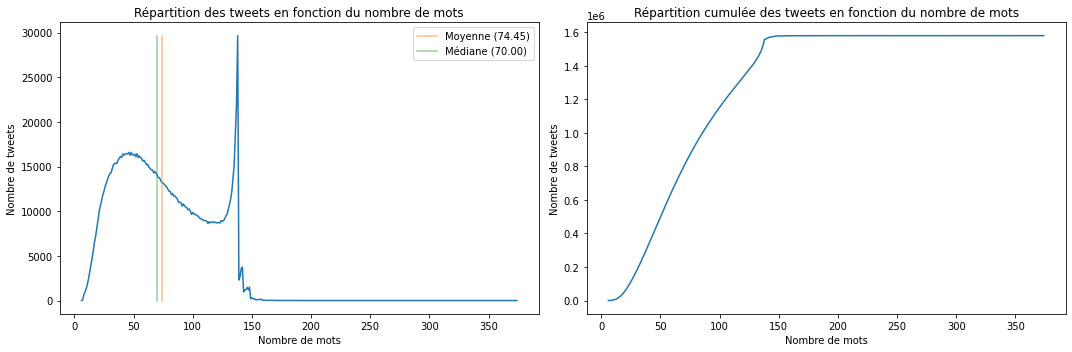

In [103]:
data_tmp = df.copy()
data_tmp['tweet_size'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(data_tmp, 'tweet_size')